In [2]:
import os
from time import time
import numpy as np
import sys
sys.path.append('../')

from utils.codification_cnn import CNNLayer, NNLayer, ChromosomeCNN, FitnessCNN, FitnessCNNParallel
from utils.datamanager import DataManager
from utils.codification_skipc import ChromosomeSkip, Connections
from GA.parentSelector.parentSelector import RandomParentSelector, TournamentSelection, LinealOrder, WheelSelection
from GA.geneticAlgorithm import GenerationalGA, TwoLevelGA


Using TensorFlow backend.


In [12]:
# Chromosome parameters
mutation_rate = 0.05
mutation_rate_1 = mutation_rate * 2
ChromosomeSkip.grow_prob = mutation_rate_1
ChromosomeSkip.decrease_prob = mutation_rate_1
ChromosomeSkip.skip_prob = 0.4

CNNLayer.k_prob = mutation_rate
CNNLayer.filter_prob = mutation_rate_1
CNNLayer.act_prob = mutation_rate
CNNLayer.drop_prob = mutation_rate_1
CNNLayer.maxpool_prob = mutation_rate

NNLayer.units_prob = mutation_rate_1
NNLayer.act_prob = mutation_rate
NNLayer.drop_prob = mutation_rate_1

CNNLayer.filters_lim = 128
CNNLayer.possible_activations = ['relu', 'elu', 'prelu']

data_folder = '../../datasets'
command = 'python3 ../train_gen.py'
verbose = 0
experiments_folder = '../../exp_complete_skip_aug'
experiments_folder = '../../exp_complete_skip'

gpus = 2
skip = True

'''
data_folder = '/home/daniel/datasets/MNIST_variations'
command = 'python ./../train_gen.py'
verbose = 1
experiments_folder = '../exps_testing'
gpus = 1
skip = 1
'''

"\ndata_folder = '/home/daniel/datasets/MNIST_variations'\ncommand = 'python ./../train_gen.py'\nverbose = 1\nexperiments_folder = '../exps_testing'\ngpus = 1\nskip = 1\n"

In [4]:
os.listdir('../')

['GA_MNIST_CNN.ipynb',
 'GA',
 'pruebas.ipynb',
 'GA.py',
 'README.md',
 'Fistness_str_example.ipynb',
 '.gitignore',
 '.git',
 'train_gen.py',
 'EvoCNN.ipynb',
 'utils',
 'LICENSE',
 '.idea',
 'experiments',
 'parallel_train_test.ipynb',
 'GA_MNIST_mlp.py',
 'tests',
 'exps_testing',
 'GA_MNIST_mlp.ipynb',
 'resources']

In [5]:
experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)

fitness_cnn = FitnessCNN()

l = CNNLayer(32, (3,3), 'relu', 0, False)
l2 = CNNLayer(64, (3,3), 'relu', 0.25, True)
l3 = NNLayer(128, 'relu', 0.5)
c = ChromosomeCNN([l, l2], [l3])
if skip:
    c = ChromosomeSkip(c.cnn_layers, c.nn_layers, Connections.random_connections(len(c.cnn_layers)))
    

In [6]:
d = c.random_individual()

In [7]:
print(d)

CNN|F:69|K:(1,7)|A:elu|D:0.651|M:0
CNN|F:97|K:(1,5)|A:prelu|D:0.517|M:0
CNN|F:90|K:(3,3)|A:prelu|D:0.089|M:0
CNN|F:79|K:(1,7)|A:elu|D:0.357|M:0
1
11
111



In [8]:
# dataset params:
data_folder = data_folder
classes = []

# genetic algorithm params:
generations=30
population_first_level=20
population_second_level=8
training_hours=16
save_progress=True
maximize_fitness=False
statistical_validation=False
frequency_second_level=2
start_level2 = 1


# Fitness params
epochs = 15
batch_size = 128
verbose = verbose
redu_plat = False
early_stop = 30
warm_up_epochs= 0
base_lr = 0.05
smooth = 0.1
cosine_dec = False
lr_find = False
precise_eps = 75

datasets = ['MB', 'MBI', 'MRB', 'MRD', 'MRDBI']
datasets = ['cifar10']


EVOLVING IN DATASET cifar10 ...

(40000, 32, 32, 3) train samples
(10000, 32, 32, 3) validation samples
(10000, 32, 32, 3) test samples
Number of individuals eliminated by age: 0
Genetic algorithm params
Number of generations: 30
Population size: 20
Folder to save: ../../exp_complete_skip/cifar10/genetic/0_2019-11-15-16:57/GA_experiment
num parents: 5
offspring size: 15

Population size level one: 20
Population size level two: 8
Number of parents level one: 5
Number of parents level two: 4
Offspring size level one: 15
Offspring size level two: 4
Creating Initial population

Start evolution process...


0) Ranking level 1... Models to train: 20 ...OK (in 14.44 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.001

1) Ranking level 1... Models to train: 14 ...OK (in 16.01 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.001

1) Ranking level 2... Models to train: 8 ...OK (in 58.67 minutes)
Saving... Elapsed saved time: 0.001



22) Ranking level 2... Models to train: 2 ...OK (in 27.55 minutes)
Saving... Elapsed saved time: 0.001

Generation (22) in 2050.66 minutes.
Best first level fitness: 0.11100
Best second level fitness: 0.09030

23) Ranking level 1... Models to train: 14 ...OK (in 34.37 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.001

23) Ranking level 2... Models to train: 4 ...OK (in 50.95 minutes)
Saving... Elapsed saved time: 0.001

Generation (23) in 2135.97 minutes.
Best first level fitness: 0.11100
Best second level fitness: 0.09030

24) Ranking level 1... Models to train: 15 ...OK (in 36.39 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.001

24) Ranking level 2... Models to train: 0 ...OK (in 0.00 minutes)
Saving... Elapsed saved time: 0.001

Generation (24) in 2172.36 minutes.
Best first level fitness: 0.11100
Best second level fitness: 0.09030

25) Ranking level 1... Models to train: 15 ...OK (in 36.92 minutes)
Statistical val

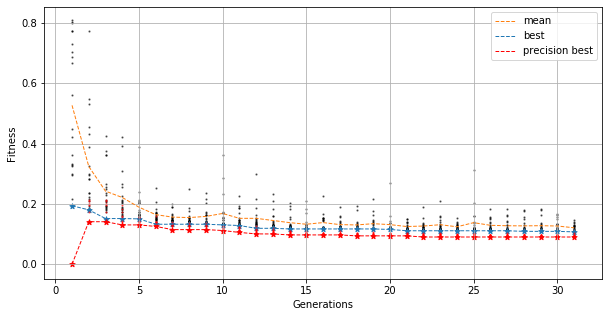

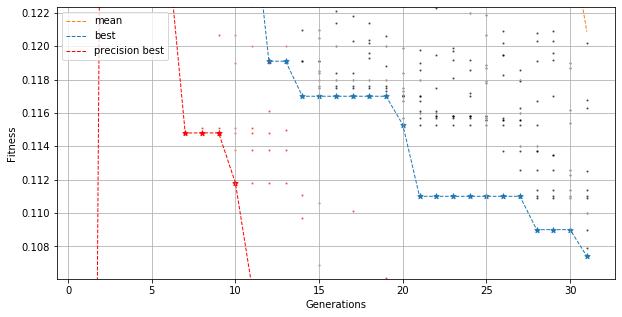

Total elapsed time: 158402.334


In [12]:
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)

    # Load data
    dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder) #, max_examples=8000)
    data = dm.load_data()
    fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                   epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                   warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                   precise_epochs=precise_eps)

    fitness_cnn.save(fitness_file)

    del dm, data
    
    fitness = FitnessCNNParallel()
    fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                   fp=32, main_line=command)
    generational = TwoLevelGA(chromosome=c,
                              fitness=fitness,
                              generations=generations,
                              population_first_level=population_first_level,
                              population_second_level=population_second_level,
                              training_hours=training_hours,
                              save_progress=save_progress,
                              maximize_fitness=maximize_fitness,
                              statistical_validation=statistical_validation,
                              folder=folder,
                              start_level2=start_level2,
                              frequency_second_level=frequency_second_level)
        
    ti_all = time()
    winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))

In [ ]:
ranking1 = generational.evaluate_population(level=1)
ranking2 = generational.evaluate_population(level=2)

In [ ]:
ranking1

In [ ]:
ranking2

Training... MAXPOOL
MAXPOOL
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 45)        1260      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 45)        180       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 45)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 102)       68952     
_________________________________________________________________
batch_normalization_3 (Batch (N

Epoch 27/200
40000/40000 [==============================] - 14s 351us/step - loss: 0.7771 - accuracy: 0.8915 - val_loss: 0.4787 - val_accuracy: 0.8563
Epoch 28/200
40000/40000 [==============================] - 14s 354us/step - loss: 0.7664 - accuracy: 0.8954 - val_loss: 0.4385 - val_accuracy: 0.8683
Epoch 29/200
40000/40000 [==============================] - 14s 351us/step - loss: 0.7664 - accuracy: 0.8953 - val_loss: 0.4472 - val_accuracy: 0.8656
Epoch 30/200
40000/40000 [==============================] - 14s 352us/step - loss: 0.7551 - accuracy: 0.9021 - val_loss: 0.4692 - val_accuracy: 0.8515
Epoch 31/200
40000/40000 [==============================] - 14s 358us/step - loss: 0.7535 - accuracy: 0.9018 - val_loss: 0.4630 - val_accuracy: 0.8603
Epoch 32/200
40000/40000 [==============================] - 14s 353us/step - loss: 0.7532 - accuracy: 0.9021 - val_loss: 0.3975 - val_accuracy: 0.8771
Epoch 33/200
40000/40000 [==============================] - 14s 351us/step - loss: 0.7556 - ac

40000/40000 [==============================] - 14s 352us/step - loss: 0.6622 - accuracy: 0.9468 - val_loss: 0.4058 - val_accuracy: 0.8879
Epoch 82/200
40000/40000 [==============================] - 14s 353us/step - loss: 0.6615 - accuracy: 0.9475 - val_loss: 0.3846 - val_accuracy: 0.8897
Epoch 83/200
40000/40000 [==============================] - 15s 368us/step - loss: 0.6606 - accuracy: 0.9479 - val_loss: 0.4161 - val_accuracy: 0.8833
Epoch 84/200
40000/40000 [==============================] - 15s 367us/step - loss: 0.6597 - accuracy: 0.9473 - val_loss: 0.4493 - val_accuracy: 0.8789
Epoch 85/200
40000/40000 [==============================] - 15s 364us/step - loss: 0.6598 - accuracy: 0.9482 - val_loss: 0.3940 - val_accuracy: 0.8908
Epoch 86/200
40000/40000 [==============================] - 14s 354us/step - loss: 0.6563 - accuracy: 0.9489 - val_loss: 0.4038 - val_accuracy: 0.8845
Epoch 87/200
40000/40000 [==============================] - 14s 362us/step - loss: 0.6582 - accuracy: 0.949

40000/40000 [==============================] - 14s 340us/step - loss: 0.5948 - accuracy: 0.9754 - val_loss: 0.3658 - val_accuracy: 0.8995
Epoch 136/200
40000/40000 [==============================] - 14s 345us/step - loss: 0.5914 - accuracy: 0.9766 - val_loss: 0.3688 - val_accuracy: 0.8953
Epoch 137/200
40000/40000 [==============================] - 14s 341us/step - loss: 0.5903 - accuracy: 0.9767 - val_loss: 0.3557 - val_accuracy: 0.9031
Epoch 138/200
40000/40000 [==============================] - 14s 341us/step - loss: 0.5876 - accuracy: 0.9776 - val_loss: 0.3626 - val_accuracy: 0.9010
Epoch 139/200
40000/40000 [==============================] - 14s 345us/step - loss: 0.5882 - accuracy: 0.9779 - val_loss: 0.3703 - val_accuracy: 0.8983
Epoch 140/200
40000/40000 [==============================] - 14s 342us/step - loss: 0.5875 - accuracy: 0.9782 - val_loss: 0.3650 - val_accuracy: 0.8986
Epoch 141/200
40000/40000 [==============================] - 14s 343us/step - loss: 0.5844 - accuracy:

Epoch 189/200
40000/40000 [==============================] - 14s 343us/step - loss: 0.5509 - accuracy: 0.9910 - val_loss: 0.3409 - val_accuracy: 0.9077
Epoch 190/200
40000/40000 [==============================] - 14s 342us/step - loss: 0.5511 - accuracy: 0.9905 - val_loss: 0.3429 - val_accuracy: 0.9098
Epoch 191/200
40000/40000 [==============================] - 14s 341us/step - loss: 0.5513 - accuracy: 0.9900 - val_loss: 0.3433 - val_accuracy: 0.9118
Epoch 192/200
40000/40000 [==============================] - 14s 342us/step - loss: 0.5490 - accuracy: 0.9915 - val_loss: 0.3437 - val_accuracy: 0.9090
Epoch 193/200
40000/40000 [==============================] - 14s 340us/step - loss: 0.5489 - accuracy: 0.9912 - val_loss: 0.3417 - val_accuracy: 0.9102
Epoch 194/200
40000/40000 [==============================] - 14s 344us/step - loss: 0.5483 - accuracy: 0.9916 - val_loss: 0.3445 - val_accuracy: 0.9088
Epoch 195/200
40000/40000 [==============================] - 14s 343us/step - loss: 0.54

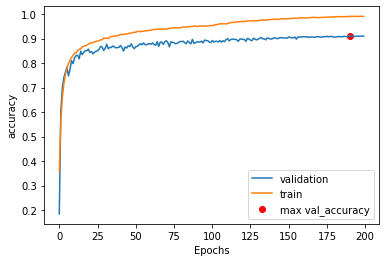

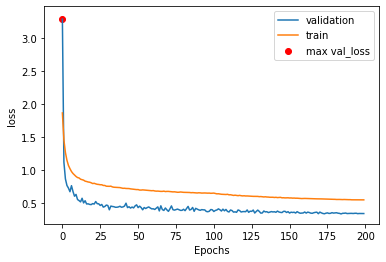

0.0899 in 46.8 min



In [18]:
fitness_cnn.precise_epochs = 200
fitness_cnn.verb = True
fitness_cnn.smooth = 0.1
fitness_cnn.learning_rate_base = 0.05
score = fitness_cnn.calc(w, test=True, precise_mode=True, augmnt=False)

In [ ]:
w = generational.best_individual['winner']

In [ ]:
print(generational.history_fitness[w.__repr__()])
print(generational.history_precision_fitness[w.__repr__()])

In [ ]:
generational.best_individual

In [ ]:
for k,f in generational.history_precision_fitness.items():
    print(k,f, end="\n"*2)

In [21]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

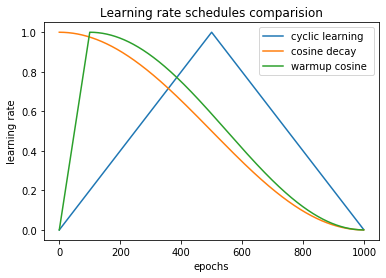

In [52]:
x = np.arange(1000)
N  = len(x) / 2
clrs = (-np.abs(x - N) + N) / N

n = 2 * N
cosine = np.cos(2 * np.pi* x / (4 * n)) ** 2

warmup_cosine = [xi / (n / 10.) if xi < (n/10) else np.cos(2 * np.pi* (xi -(n / 10.))  / (4 * 9 * n / 10)) ** 2 for xi in x ] 
plt.plot(x, clrs, label='cyclic learning')
plt.plot(x, cosine, label='cosine decay')
plt.plot(x, warmup_cosine, label='warmup cosine ')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('learning rate')
plt.title('Learning rate schedules comparision')
plt.savefig(fname='../../learning_rates_schedules')
plt.show()

In [51]:
import os
os.listdir('../../')

['exps', 'NeuroEvolution', 'documentos', 'nasbench']

In [26]:
1-0.0895

0.9105

In [8]:
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)

    # Load data
    dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder) #, max_examples=8000)
    data = dm.load_data()
    fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                   epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                   warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                   precise_epochs=precise_eps)

    fitness_cnn.save(fitness_file)

    del dm, data
    
    fitness = FitnessCNNParallel()
    fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                   fp=32, main_line=command)
    generational = TwoLevelGA.load_genetic_algorithm( folder=folder)
        
   


EVOLVING IN DATASET cifar10 ...

(40000, 32, 32, 3) train samples
(10000, 32, 32, 3) validation samples
(10000, 32, 32, 3) test samples
Loading file ../../exp_complete_skip/cifar10/genetic/0_2019-11-15-16:57/GA_experiment


In [9]:
w = generational.best_individual['winner']
w.fp = 32

In [10]:
# Fitness params
epochs = 108
batch_size = 128
verbose = True
redu_plat = False
early_stop = 30
warm_up_epochs= 0
base_lr = 0.05
smooth = 0.1
cosine_dec = False
lr_find = False
precise_eps = 200


# Load data
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder) #, max_examples=8000)
data = dm.load_data()
fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                   epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                   warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                   precise_epochs=precise_eps)


(40000, 32, 32, 3) train samples
(10000, 32, 32, 3) validation samples
(10000, 32, 32, 3) test samples


Training... MAXPOOL
MAXPOOL
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 45)        1260      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 45)        180       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 45)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 102)       68952     
_________________________________________________________________
batch_normalization_3 (Batch (N

312/312 [==============================] - 14s 46ms/step - loss: 0.9021 - accuracy: 0.8325 - val_loss: 0.4903 - val_accuracy: 0.8457
Epoch 29/200
312/312 [==============================] - 14s 45ms/step - loss: 0.8941 - accuracy: 0.8368 - val_loss: 0.5791 - val_accuracy: 0.8252
Epoch 30/200
312/312 [==============================] - 14s 46ms/step - loss: 0.8949 - accuracy: 0.8347 - val_loss: 0.5020 - val_accuracy: 0.8430
Epoch 31/200
312/312 [==============================] - 14s 45ms/step - loss: 0.8955 - accuracy: 0.8344 - val_loss: 0.4496 - val_accuracy: 0.8681
Epoch 32/200
312/312 [==============================] - 14s 46ms/step - loss: 0.8881 - accuracy: 0.8385 - val_loss: 0.4629 - val_accuracy: 0.8557
Epoch 33/200
312/312 [==============================] - 14s 46ms/step - loss: 0.8869 - accuracy: 0.8392 - val_loss: 0.4663 - val_accuracy: 0.8574
Epoch 34/200
312/312 [==============================] - 15s 47ms/step - loss: 0.8842 - accuracy: 0.8419 - val_loss: 0.4525 - val_accuracy

312/312 [==============================] - 15s 47ms/step - loss: 0.8009 - accuracy: 0.8801 - val_loss: 0.3615 - val_accuracy: 0.8932
Epoch 85/200
312/312 [==============================] - 14s 45ms/step - loss: 0.7954 - accuracy: 0.8857 - val_loss: 0.3890 - val_accuracy: 0.8960
Epoch 86/200
312/312 [==============================] - 14s 46ms/step - loss: 0.7959 - accuracy: 0.8833 - val_loss: 0.4133 - val_accuracy: 0.8823
Epoch 87/200
312/312 [==============================] - 14s 46ms/step - loss: 0.7958 - accuracy: 0.8843 - val_loss: 0.3425 - val_accuracy: 0.9012
Epoch 88/200
312/312 [==============================] - 14s 46ms/step - loss: 0.7893 - accuracy: 0.8854 - val_loss: 0.3417 - val_accuracy: 0.9067
Epoch 89/200
312/312 [==============================] - 15s 47ms/step - loss: 0.7986 - accuracy: 0.8824 - val_loss: 0.4148 - val_accuracy: 0.8898
Epoch 90/200
312/312 [==============================] - 14s 46ms/step - loss: 0.7907 - accuracy: 0.8867 - val_loss: 0.3569 - val_accuracy

Epoch 140/200
312/312 [==============================] - 14s 44ms/step - loss: 0.7140 - accuracy: 0.9182 - val_loss: 0.3168 - val_accuracy: 0.9160
Epoch 141/200
312/312 [==============================] - 14s 45ms/step - loss: 0.7096 - accuracy: 0.9213 - val_loss: 0.3183 - val_accuracy: 0.9148
Epoch 142/200
312/312 [==============================] - 14s 44ms/step - loss: 0.7084 - accuracy: 0.9217 - val_loss: 0.3088 - val_accuracy: 0.9179
Epoch 143/200
312/312 [==============================] - 14s 45ms/step - loss: 0.7072 - accuracy: 0.9221 - val_loss: 0.3027 - val_accuracy: 0.9203
Epoch 144/200
312/312 [==============================] - 14s 45ms/step - loss: 0.7057 - accuracy: 0.9229 - val_loss: 0.3114 - val_accuracy: 0.9135
Epoch 145/200
312/312 [==============================] - 14s 45ms/step - loss: 0.7091 - accuracy: 0.9198 - val_loss: 0.3173 - val_accuracy: 0.9180
Epoch 146/200
312/312 [==============================] - 14s 45ms/step - loss: 0.7044 - accuracy: 0.9237 - val_loss: 0

Epoch 196/200
312/312 [==============================] - 14s 46ms/step - loss: 0.6510 - accuracy: 0.9449 - val_loss: 0.2829 - val_accuracy: 0.9272
Epoch 197/200
312/312 [==============================] - 14s 45ms/step - loss: 0.6493 - accuracy: 0.9458 - val_loss: 0.2816 - val_accuracy: 0.9273
Epoch 198/200
312/312 [==============================] - 14s 45ms/step - loss: 0.6493 - accuracy: 0.9456 - val_loss: 0.2791 - val_accuracy: 0.9284
Epoch 199/200
312/312 [==============================] - 14s 45ms/step - loss: 0.6497 - accuracy: 0.9457 - val_loss: 0.2797 - val_accuracy: 0.9280
Epoch 200/200
312/312 [==============================] - 14s 46ms/step - loss: 0.6488 - accuracy: 0.9459 - val_loss: 0.2817 - val_accuracy: 0.9285
Acc -> Val acc: 0.0707,Test (best_acc) acc: 0.0799


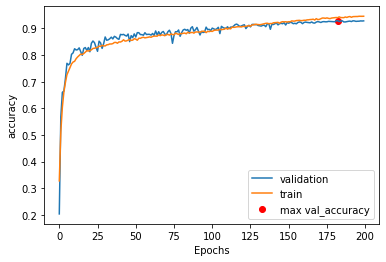

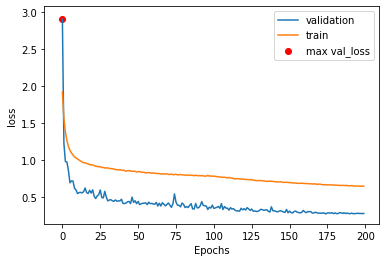

0.0799 in 48.7 min



0.07990002632141113

In [11]:
fitness_cnn.calc(w, test=True, precise_mode=True, augmnt=True)

#### Evolving with data augmentation

In [9]:
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)

    # Load data
    dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder) #, max_examples=8000)
    data = dm.load_data()
    fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                   epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                   warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                   precise_epochs=precise_eps)

    fitness_cnn.save(fitness_file)

    del dm, data
    
    fitness = FitnessCNNParallel()
    fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                   fp=32, main_line=command)
    generational = TwoLevelGA(chromosome=c,
                              fitness=fitness,
                              generations=generations,
                              population_first_level=population_first_level,
                              population_second_level=population_second_level,
                              training_hours=training_hours,
                              save_progress=save_progress,
                              maximize_fitness=maximize_fitness,
                              statistical_validation=statistical_validation,
                              folder=folder,
                              start_level2=start_level2,
                              frequency_second_level=frequency_second_level)
        
    ti_all = time()
    winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))


EVOLVING IN DATASET cifar10 ...

(40000, 32, 32, 3) train samples
(10000, 32, 32, 3) validation samples
(10000, 32, 32, 3) test samples
Number of individuals eliminated by age: 0
Genetic algorithm params
Number of generations: 30
Population size: 20
Folder to save: ../../exp_complete_skip_aug/cifar10/genetic/0_2019-11-21-16:48/GA_experiment
num parents: 5
offspring size: 15

Population size level one: 20
Population size level two: 8
Number of parents level one: 5
Number of parents level two: 4
Offspring size level one: 15
Offspring size level two: 4
Creating Initial population

Start evolution process...


0) Ranking level 1... Models to train: 20 ...OK (in 31.14 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.001

1) Ranking level 1... Models to train: 11 ...OK (in 19.17 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.001

1) Ranking level 2... Models to train: 8 ...OK (in 72.50 minutes)
Saving... Elapsed saved time: 0.0

KeyboardInterrupt: 

Training... WARNING:tensorflow:Large dropout rate: 0.539918 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
MAXPOOL
MAXPOOL
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 44)   1232        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
b

312/312 [==============================] - 28s 89ms/step - loss: 0.9676 - accuracy: 0.8167 - val_loss: 0.7420 - val_accuracy: 0.7647
Epoch 10/75
312/312 [==============================] - 29s 93ms/step - loss: 0.9530 - accuracy: 0.8265 - val_loss: 0.5822 - val_accuracy: 0.8220
Epoch 11/75
312/312 [==============================] - 28s 91ms/step - loss: 0.9465 - accuracy: 0.8277 - val_loss: 0.5912 - val_accuracy: 0.8332
Epoch 12/75
312/312 [==============================] - 28s 90ms/step - loss: 0.9346 - accuracy: 0.8320 - val_loss: 0.6712 - val_accuracy: 0.7943
Epoch 13/75
312/312 [==============================] - 28s 90ms/step - loss: 0.9296 - accuracy: 0.8345 - val_loss: 0.5881 - val_accuracy: 0.8359
Epoch 14/75
312/312 [==============================] - 29s 94ms/step - loss: 0.9191 - accuracy: 0.8420 - val_loss: 0.6327 - val_accuracy: 0.8123
Epoch 15/75
312/312 [==============================] - 28s 89ms/step - loss: 0.9176 - accuracy: 0.8415 - val_loss: 0.5474 - val_accuracy: 0.83

312/312 [==============================] - 28s 90ms/step - loss: 0.6869 - accuracy: 0.9506 - val_loss: 0.3705 - val_accuracy: 0.9143
Epoch 66/75
312/312 [==============================] - 28s 90ms/step - loss: 0.6777 - accuracy: 0.9541 - val_loss: 0.3531 - val_accuracy: 0.9153
Epoch 67/75
312/312 [==============================] - 28s 90ms/step - loss: 0.6794 - accuracy: 0.9547 - val_loss: 0.3900 - val_accuracy: 0.9133
Epoch 68/75
312/312 [==============================] - 28s 91ms/step - loss: 0.6711 - accuracy: 0.9572 - val_loss: 0.3619 - val_accuracy: 0.9162
Epoch 69/75
312/312 [==============================] - 28s 91ms/step - loss: 0.6687 - accuracy: 0.9597 - val_loss: 0.3707 - val_accuracy: 0.9151
Epoch 70/75
312/312 [==============================] - 29s 93ms/step - loss: 0.6679 - accuracy: 0.9596 - val_loss: 0.3528 - val_accuracy: 0.9198
Epoch 71/75
312/312 [==============================] - 29s 92ms/step - loss: 0.6603 - accuracy: 0.9627 - val_loss: 0.3600 - val_accuracy: 0.91

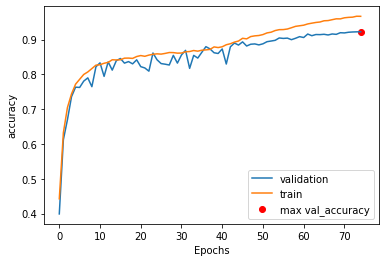

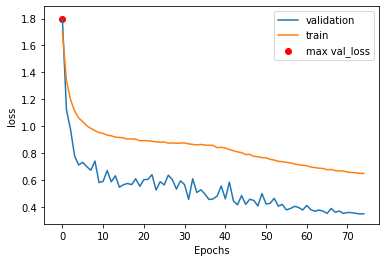

0.0856 in 36.8 min



0.08560001850128174

In [11]:
w = generational.best_individual['winner']
w.fp = 32
fitness_cnn.verb = True
fitness_cnn.calc(w, test=True, precise_mode=True, augmnt=True)

In [13]:
generational.best_individual

{'winner': CNN|F:44|K:(3,3)|A:elu|D:0.339|M:0
 CNN|F:44|K:(3,3)|A:elu|D:0.339|M:0
 CNN|F:66|K:(3,7)|A:prelu|D:0.300|M:0
 CNN|F:93|K:(7,7)|A:elu|D:0.540|M:0
 CNN|F:52|K:(3,7)|A:relu|D:0.077|M:1
 CNN|F:103|K:(3,7)|A:relu|D:0.055|M:1
 CNN|F:106|K:(5,7)|A:relu|D:0.057|M:0
 1
 01
 001
 0011
 00001
 001001, 'best_fit': 0.0783}